### Agentic RAG

We will be building an Agentic RAG. Retrieval Agent comes in handy when we want LLM to decide when to retrieve context from vector store or respond directly to user query.

<img src="./images/Agentic_RAG.png" alt="Agentic RAG" width="1000"/>

Let's discuss the Agentic RAG architecture:

1. **LLM Supervisor** : Decides when to retrieve from vectore store and when to repond directly.

2. **Vectore Retriver** : Retriever tool which will provide us the context based on user query.

3. **Grader** : Decides based if retrieved context is relevant to user query, if not, redirect to rewrite query else output generator.

4. **Output Generator** : Generates the final output based on the retrieved context.

5. **Rewriter** : Rewrites query and redirect it to LLM Supervisor to run the loop again until relevant context is retrieved.


In [144]:
## Setup
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_community.document_loaders import WebBaseLoader
from langchain_groq import ChatGroq

In [4]:
## Load LLM model
model = 'qwen/qwen3-32b'
llm = ChatGroq(model=model)

Reading all the urls from a text file.

In [145]:
with open('url.txt','r') as file:
    urls = file.read().splitlines()


In [36]:
from bs4 import SoupStrainer

Loading all the documents in a list of documents.

In [ ]:
docs = [WebBaseLoader(web_path=url,bs_kwargs={'parse_only': SoupStrainer('main', class_='wp-block-group is-layout-flow wp-block-group-is-layout-flow')}).load() for url in urls]


As web scraped data can have multiple line brakes and spaces we need to clean the content of each document extracted.

In [68]:
## cleaning data
import re
cleaned_docs = []
for i,doc in enumerate(docs):
    original_content = doc[0].page_content
    
    category_block_pattern = re.compile(
        r'(?:'               # Start a non-capturing group for repeated lines
        r'(?: {2,}|\t+)'     # Match 2 or more spaces OR one or more tabs (for indentation)
        r'[A-Za-z& ]+'       # Match the category text (letters, ampersands, spaces)
        r'\s*'               # Match any trailing whitespace on the line
        r'\n'                # Match the newline at the end of the category line
        r')+'                # Match one or more such category lines
        , re.IGNORECASE      # Make "All Categories" case-insensitive
    )
    # Use sub to replace the entire matched block with an empty string
    temp_content = re.sub(category_block_pattern, '', original_content, count=1)
    
    #temp_content = re.sub(r'\n+','\n',temp_content)
    
    # Step 2: Normalize Line Breaks (reduce 3+ newlines to two)
    # This preserves single and double newlines for paragraph breaks
    temp_content = re.sub(r'\n{3,}', '\n', temp_content)
    
    # Step 3: Normalize Spaces (reduce 2+ spaces/tabs to a single space)
    # This also handles other horizontal whitespace characters like tabs
    temp_content = re.sub(r'[ \t]{2,}', ' ', temp_content)
    
    # Step 4: Final strip of leading/trailing whitespace
    cleaned_content = temp_content.strip()
    
    doc[0].page_content = cleaned_content
    cleaned_docs.append(doc)

In [146]:
print(cleaned_docs[1][0].page_content[0:200])

About us
Be certain.
We’re in the business of giving you certainty. At Acera Insurance, all that we do revolves around giving our clients the best service experience and the utmost confidence in what 


#### We have got cleaned data, now we will split the data into smaller chunks

In [76]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

doc_list = [item for sublist in cleaned_docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size = 500, chunk_overlap = 50)

doc_splits = text_splitter.split_documents(doc_list)

In [147]:
print(doc_splits[10].page_content[0:200])

Speak to your broker for more details on trip cancellation insurance. This coverage can be very valuable – especially when cancellations are so common due to the pandemic. However, not all scenarios a


#### We have split our documents, now we will store it in vectore store and will create a retriever. We will be usign Chroma VS.

In [84]:
from langchain_openai import OpenAIEmbeddings
openai_embedding = OpenAIEmbeddings(model = 'text-embedding-3-large')

In [85]:
from langchain_community.vectorstores import Chroma

vectore_store = Chroma.from_documents(
    documents=doc_splits,
    collection_name='acera_rag',
    embedding=openai_embedding
)

retriever = vectore_store.as_retriever()

In [120]:
retriever.invoke('How many employees are in Acera')

[Document(metadata={'source': 'https://acera.ca/careers/'}, page_content='Careers at Acera Insurance\nChanging the way people feel about a career in insurance.\nChoose a career that empowers you to excel in and take ownership of your work, while having fun. Choose a career with Acera Insurance — we put people first!\n\nSee Current Opportunities\nBe a part of our growing team.\nAs an employer of choice, Acera Insurance offers an outstanding workplace and employee culture that creates valuable opportunities for all of our employees.\nChoosing a career with Acera Insurance means you’ll be:\n\nEncouraged to challenge the status quo and never stop learning in your commitment to excellence.\nEmpowered with a sense of accountability and autonomy to take ownership of your work.\nTreated with respect as we put our people first.\nRecognized for your achievements and engaged in festivities — big and small — that make work fun.'),
 Document(metadata={'source': 'https://acera.ca/careers/'}, page_co

#### Now we will create a retriever tool

In [121]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='acera_retriever',
    description='''
    Search and return information about Acera Insurance. Insurance coverages and services provided by Acera Insurance. You are a specialied agent.
    Use the 'retriever_tool' **only** when the query explicitly relates to Acera Insurance and Insurance Coverage. For all other queries, respond directly without using any tool. 
    For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    '''
)

In [122]:
retriever_tool.invoke('How many employees are in Acera')

'Careers at Acera Insurance\nChanging the way people feel about a career in insurance.\nChoose a career that empowers you to excel in and take ownership of your work, while having fun. Choose a career with Acera Insurance — we put people first!\n\nSee Current Opportunities\nBe a part of our growing team.\nAs an employer of choice, Acera Insurance offers an outstanding workplace and employee culture that creates valuable opportunities for all of our employees.\nChoosing a career with Acera Insurance means you’ll be:\n\nEncouraged to challenge the status quo and never stop learning in your commitment to excellence.\nEmpowered with a sense of accountability and autonomy to take ownership of your work.\nTreated with respect as we put our people first.\nRecognized for your achievements and engaged in festivities — big and small — that make work fun.\n\nIf this sounds good to you, come join our network of more than 1,300 professionals.\nAbout Acera Insurance\nAs the largest independent, empl

In [89]:
from langgraph.prebuilt import ToolNode, tools_condition

retriever_node = ToolNode([retriever_tool])

#### Bind LLM with Tool and will create LLM Decision function

In [90]:
llm_with_tool = llm.bind_tools([retriever_tool])

In [92]:
from typing import Annotated, Sequence, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage

class State(TypedDict):
    messages : Annotated[List[Sequence], add_messages]

In [97]:
def LLM_Decision_Function(state: State):
    print('<-- LLM Decision -->')
    
    message = state['messages']
    last_message = message[-1]
    print(last_message)
    question = last_message.content
    
    response = llm_with_tool.invoke(question)
    
    return {'messages': [response]}

In [123]:
message = [HumanMessage(content='How many employees are there in Acera')]
LLM_Decision_Function({'messages':message})

<-- LLM Decision -->
content='How many employees are there in Acera' additional_kwargs={} response_metadata={}


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6r572jjmj', 'function': {'arguments': '{"query":"number of employees"}', 'name': 'acera_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 122, 'prompt_tokens': 158, 'total_tokens': 280, 'completion_time': 0.211150902, 'prompt_time': 0.005922592, 'queue_time': 0.059838442, 'total_time': 0.217073494}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9233114a-af96-4065-9282-93e3fed490b3-0', tool_calls=[{'name': 'acera_retriever', 'args': {'query': 'number of employees'}, 'id': '6r572jjmj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 158, 'output_tokens': 122, 'total_tokens': 280})]}

#### We will now create a grader function which will decide if the retrieved chunk answers the user query correctly and will redirect to next step accordingly

In [100]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.prompts import PromptTemplate

class Grader(BaseModel):
    binary_result : str = Field(description="Relevance score 'yes' or 'no'")

In [109]:
from urllib import response


def grade_documents(state: State) -> Literal['generate_answer','rewrite_question']:
    print('<-- Grade Document -->')
    
    llm_with_structured_output = llm.with_structured_output(Grader)
    
    prompt = PromptTemplate(
        template='''You are a grader assessing relevance of a retrieved document to a user question.
            Here is the retrieved document: \n\n {context}
            Here is the user question: {question}
            If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        ''',
        input_variables=['context','question']
    )
    
    chain = prompt | llm_with_structured_output
    
    message = state['messages']
    question = message[0].content
    context = message[-1].content
    
    response = chain.invoke({'question':question,'context':context})
    
    score = response.binary_result
    
    if score =='yes':
        print(print("---Decision: Docs Are Relevant-------"))
        return 'generate_answer'
    else:
        print('---Decision: Docs Are Not Relevant------------')
        return 'rewrite_question'


In [110]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How many employees are there in Acera?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        'id': 'npgbkf9js', 
                        'function': {
                            'arguments': '{"query":"number of employees"}', 
                            'name': 'acera_retriever'
                            }, 
                        'type': 'function'
                    }
                ]
            },

            {"role": "tool", "content": "If this sounds good to you, come join our network of more than 1,300 professionals.", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

<-- Grade Document -->
---Decision: Docs Are Relevant-------
None


'generate_answer'

#### We will write function to rewrite question in case the content provided by retriever is not relevant.

In [ ]:
def rewrite(state:State):
    ('<-- Rewrite User Query -->')
    
    message = state['messages']
    question = message[-1].content
    
    input = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
    ]
    
    response = llm.invoke(input)
    
    return {'messages':[response]}

#### Now we will build Generate Answer node. If we pass the grader check, we can generate the final answer based on the original question and the retrieved context.

In [138]:
from langchain import hub

def generate_answer(state: State):
    print('<-- Generate Output -->')
    
    message = state['messages']
    question = message[0].content
    context = message[-1].content
    
    prompt = PromptTemplate(
        template= '''"You are an Insurance assistant working for Acera Insurance for question-answering tasks. "
            "Use the following pieces of retrieved context to answer the question. "
            "Also provide information about coverages which Acera Insurance can provide related to user query"
            "If you don't know the answer, just say that you don't know. "
            "Use three sentences maximum and keep the answer concise.\n"
            "Question: {question} \n"
            "Context: {context}"
        '''
    )
    
    rag_llm = prompt | llm
    response = rag_llm.invoke({'question':question, 'context':context})
    
    return {'messages':[response]}

### Now we will create the graph

In [139]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node('LLM Supervisor', LLM_Decision_Function)
builder.add_node('Vector Retriever', retriever_node)
builder.add_node('Query Rewriter', rewrite)
builder.add_node('Output Generator', generate_answer)

## Logic
builder.add_edge(START,'LLM Supervisor')
builder.add_conditional_edges(
    'LLM Supervisor',
    tools_condition,
    {
        'tools': 'Vector Retriever',
        END:END
    }
)
builder.add_conditional_edges(
    'Vector Retriever',
    grade_documents,
    {
        'generate_answer':'Output Generator',
        'rewrite_question':'Query Rewriter'
    }
)
builder.add_edge('Query Rewriter','LLM Supervisor')
builder.add_edge('Output Generator', END)

app = builder.compile()

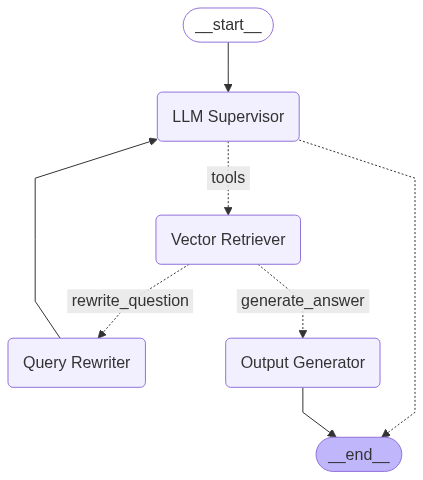

In [140]:
app

In [148]:
message = [HumanMessage(content='I live in a 2 bedroom apartment, need tenant insurance?')]
res = app.invoke({'messages':message})


<-- LLM Decision -->
content='I live in a 2 bedroom apartment, need tenant insurance?' additional_kwargs={} response_metadata={} id='2702367b-1b0f-4d21-939f-69cd6988a7bc'
<-- Grade Document -->
---Decision: Docs Are Relevant-------
None
<-- Generate Output -->


In [149]:
import pprint
for r in res['messages']:
    r.pretty_print()

================================ Human Message =================================

I live in a 2 bedroom apartment, need tenant insurance?
================================== Ai Message ==================================
Tool Calls:
  acera_retriever (t9mjw1xk5)
 Call ID: t9mjw1xk5
  Args:
    query: tenant insurance requirements for 2 bedroom apartments
================================= Tool Message =================================
Name: acera_retriever

Type of building (i.e., high-rise condo, house, etc.)
Building construction material
Distance to the nearest fire hydrant and fire station
Location and neighbourhood specifics (i.e., crime rate, proximity to natural hazards like rivers, etc.)
Your insurance and claims history
The replacement value of your personal belongings

The deductible, policy limit and any additional coverages you choose will also make a difference in your tenant insurance premium.

Is tenant insurance mandatory in Canada?
While you are not legally mandated to ca